# Let's import a bunch of stuff

In [1]:
import sys
import seaborn as sb
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import argparse
import gc

%matplotlib inline

In [2]:
adata = sc.read("CLUESImmvarMono.h5ad", cache=True)

In [3]:
adata.shape

(225297, 1342)

# Let's first cluster with slightly lower resolution

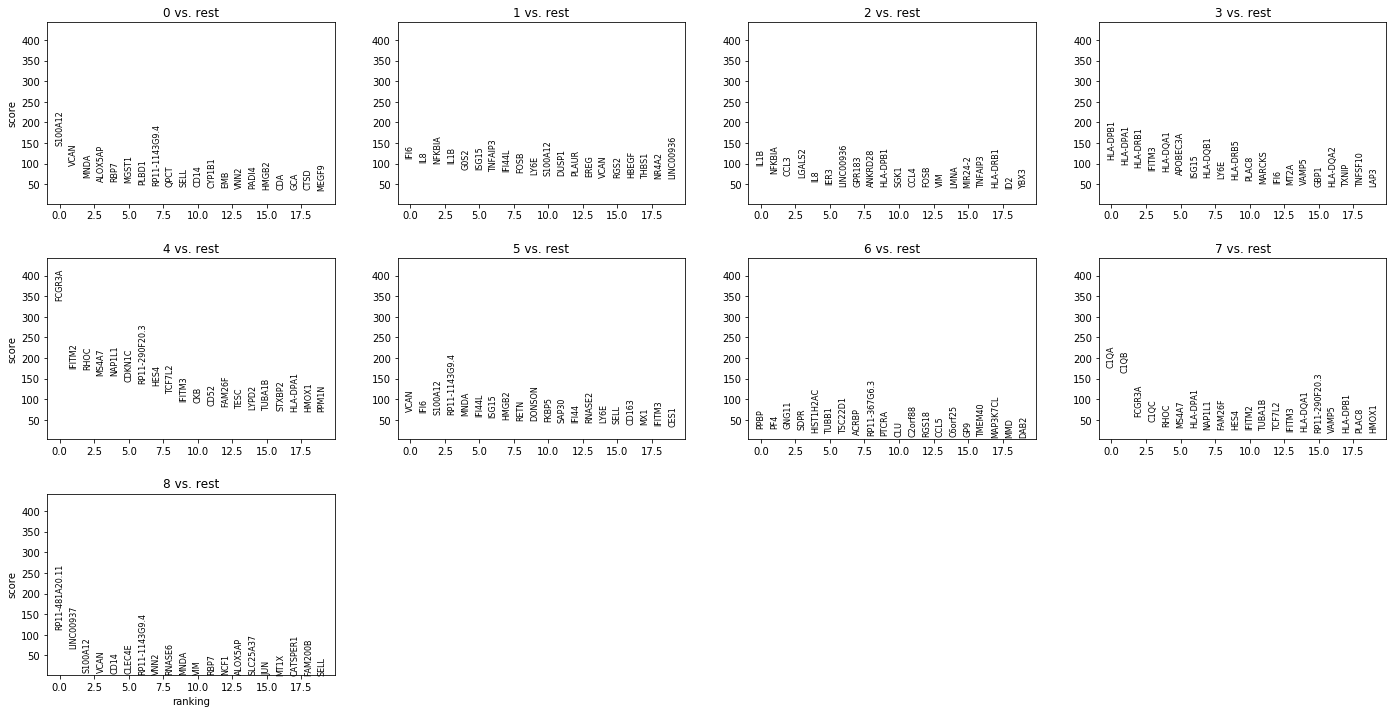

In [4]:
#get visualization of all markers and their scores
sc.tl.louvain(adata, resolution=0.75, key_added='louvain')
sc.tl.rank_genes_groups(adata, n_genes=20, groupby='louvain', use_raw=False)
sc.pl.rank_genes_groups(adata)

##sc.tl.rank_genes_groups(adata, n_genes=20, groupby='louvain', use_raw=False)

##sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=1,groupby='louvain', figsize=(15,5),palette=sc.pl.palettes.vega_20_scanpy)

##adata.obs.louvain.to_csv("louvain.txt")

## Also plot some differentially expressed genes

## And of course UMAP with the louvain clusters highlighted

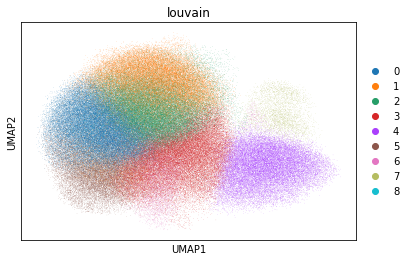

In [5]:
#plot UMAP of cell types colored by clusters
adata.uns['louvain_colors'] = sc.pl.palettes.vega_20_scanpy;
sc.pl.umap(adata, color='louvain')

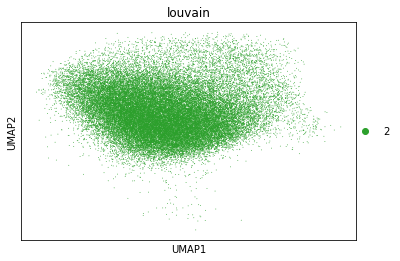

In [6]:
sc.pl.umap(adata[adata.obs.louvain=="2"], color='louvain')

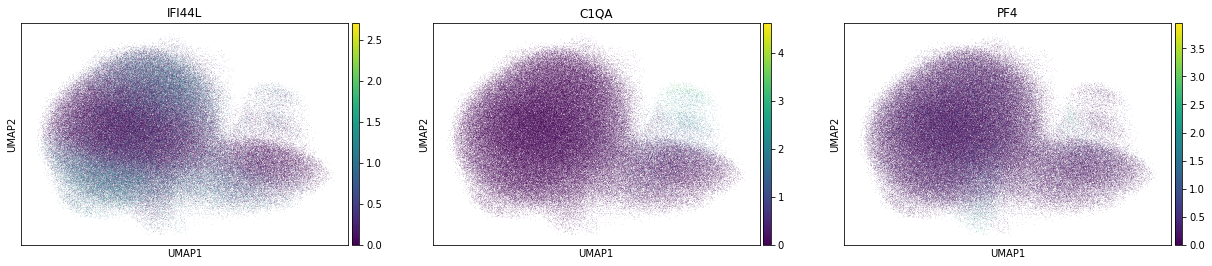

In [7]:
sc.pl.umap(adata, color=['IFI44L','C1QA','PF4'])

# Now let's plot differences in cluster proportion

In [8]:
#get counts of cells for each cluster
ct_counts=adata.obs.groupby(['ind_cov', 'disease_cov','louvain'])['louvain'].count()
ct_percs = ct_counts/ct_counts.groupby(level=[0]).transform(sum)*100
ct_percs = ct_percs.reset_index(name='ct_percs')
ct_percs.ind_cov = ct_percs.ind_cov.apply(lambda x: x.split('_')[0])
ct_percs.ind_cov = ct_percs.ind_cov.astype("str")
ct_percs.reset_index(inplace=True)
ct_percs.louvain = ct_percs.louvain.astype("category")
ct_df=ct_percs.unstack(level=2, fill_value=0)

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,12)):
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = ct_percs.ct_percs[ct_percs.louvain==ct]
    disease = ct_percs.disease_cov[ct_percs.louvain==ct]
    disease = disease.astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    ##data = data.assign(ct_perc=ct_perc)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))

# #box plot as a proportion of cell type
# vars=[str(x) for x in list(range(n_cts))]
# ct_df['ind_cov']=ct_df.index.get_level_values('ind_cov').tolist()
# ct_df.index=ct_df['ind_cov']
# melted=pd.melt(ct_df, id_vars=['ind_cov', 'disease'], value_vars=vars)

#plot=sb.boxplot(x='disease', y='value', hue=ct_arg, data=melted).get_figure()
plt.figure(figsize=(15,8))
plot=sb.catplot(x='disease_cov', y='ct_percs', hue='louvain', data=ct_percs, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=False, palette=sc.pl.palettes.vega_20_scanpy)
#plt.subplots_adjust(wspace=0.03)

as a proportion of cell type
Cluster type:0
Beta=8.112824525885628, pvalue=0.00046841495080204306
Cluster type:1
Beta=-8.162265620918365, pvalue=0.01418757964916172
Cluster type:2
Beta=6.854732706983935, pvalue=0.010934414463258223
Cluster type:3
Beta=-1.3496133608375356, pvalue=0.35956967073669754
Cluster type:4
Beta=2.734260511131045, pvalue=0.025451461927320045
Cluster type:5
Beta=-6.639312407951665, pvalue=0.0015712339021858135
Cluster type:6
Beta=-1.9902671588598773, pvalue=2.1865791371799695e-06
Cluster type:7
Beta=-0.545009557909784, pvalue=0.0007774449377222854
Cluster type:8
Beta=0.30595077587333136, pvalue=0.00036579147801284775


IndexError: index 9 is out of bounds for axis 0 with size 9

# Let's also plot the absolutely abundance of each cluster

In [ ]:
## Let's grab the clinical and labs data and compare to our single cell estimates
clues_clinical = pd.read_table("v2.clinical.data.txt", index_col=False)
clues_clinical.genotypeid = clues_clinical.genotypeid.apply(lambda x: x.split('_')[0])
clues_clinical.subjectid = clues_clinical.subjectid.astype("str")
joined = ct_percs.join(clues_clinical.set_index('genotypeid'), on='ind_cov')

t1_labs = pd.read_table("T1labs.csv",sep=",")
t1_labs.SubjectID = t1_labs.SubjectID.astype("str")
joined = joined.join(t1_labs.set_index('SubjectID'), on='subjectid')

### test new code
joined.AbsBaso = joined.AbsBaso/1000
joined.AbsEosino = joined.AbsEosino/1000
joined.AbsLympho = joined.AbsLympho/1000
joined.AbsNeutro = joined.AbsNeutro/1000
joined.AbsMono = joined.AbsMono/1000

joined = joined.assign(pbmc = joined.WhiteBloodCell-joined.AbsNeutro-joined.AbsEosino-joined.AbsBaso)

joined[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(str)

## now let's add in white blood cell counts for the immvar patients
immvar_pbmc = pd.read_table("immvar.pbmc.csv", index_col=False, sep=",")
immvar_pbmc.pbmc = immvar_pbmc.pbmc - (np.mean(immvar_pbmc.pbmc) - np.mean(joined.pbmc))

## this is not the most efficient code but will suffice for now
for i in list(range(12)) :
    igtb = immvar_pbmc.immvarid[i]
    joined.pbmc[joined.ind_cov==igtb] = immvar_pbmc.pbmc[i]

joined = joined.assign(estimate=joined.ct_percs/100*joined.pbmc)

joined[["ind_cov","disease_cov","louvain"]] = joined[["ind_cov","disease_cov","louvain"]].astype(str)
joined.plaquenilnow = joined.plaquenilnow.fillna(0)
joined.cellceptnow = joined.cellceptnow.fillna(0)
joined.steroralnow = joined.steroralnow.fillna(0)
joined.acrlymphopenia = joined.acrlymphopenia.fillna(0)

joined_pivot = joined.pivot_table(index=['ind_cov',"disease_cov","pbmc","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="louvain", values="estimate")
joined_pivot.reset_index(inplace=True)
joined_pivot = joined_pivot[joined_pivot.pbmc > 0]
joined_pivot.disease_cov = pd.Categorical(joined_pivot.disease_cov,categories=['healthy','sle'], ordered=True)


In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=6, figsize=(20,5))
fig.tight_layout()

for ct_i in list(range(0,6)):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.boxplot(x="disease_cov", y=ct, data=joined_pivot, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

# Let's look at the IFN score now

In [ ]:
ifn = pd.read_table("v2.ifn.sig.txt", sep=" ", index_col=False)
ifn.name = ifn.name.apply(lambda x: x.split('_')[0])
joined2 = ifn.join(joined.set_index("ind_cov"), on="name")
joined_pivot2 = joined2.pivot_table(index=['name',"disease_cov","pbmc","ifn","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="louvain", values="estimate")
joined_pivot2.reset_index(inplace=True)

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=6, figsize=(20,5))
fig.tight_layout()

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,6)):
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = joined_pivot2[ct]
    ifn = joined_pivot2.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
for ct_i in list(range(0,6)):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.scatterplot(x="ifn", y=ct, data=joined_pivot2, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    ##sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

## let's only look at disease

In [ ]:
joined_pivot2_sle = joined_pivot2[joined_pivot2.disease_cov == "sle"]

fig,ax = plt.subplots(nrows=1,ncols=6, figsize=(20,5))
fig.tight_layout()

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,6)):
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = joined_pivot2_sle[ct]
    ifn = joined_pivot2_sle.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
for ct_i in list(range(0,6)):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.scatterplot(x="ifn", y=ct, data=joined_pivot2_sle, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    ##sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

## let's only look at healthy

In [ ]:
joined_pivot2_healthy = joined_pivot2[joined_pivot2.disease_cov == "healthy"]

fig,ax = plt.subplots(nrows=1,ncols=8, figsize=(20,5))
fig.tight_layout()

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,6)):
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = joined_pivot2_healthy[ct]
    ifn = joined_pivot2_healthy.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
for ct_i in list(range(0,6)):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.scatterplot(x="ifn", y=ct, data=joined_pivot2_healthy, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    ##sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

# 6. Let's recompute the IFN score

In [ ]:
diffexp_annot = pd.read_table("ifn.analysis/diffexp.annotations.txt", sep="\t", index_col=False)
diffexp_annot.cluster = diffexp_annot.cluster.astype("category")

In [ ]:
for cluster_i in diffexp_annot.cluster.cat.categories:
    print(cluster_i)
    cluster_X = adata.X[:,adata.var_names.isin(diffexp_annot.gene[diffexp_annot.cluster==cluster_i])];
    adata.obs[cluster_i] = np.sum(cluster_X, axis=1)
    

In [ ]:
##fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5),sharex=True, sharey=True)
##fig.tight_layout()

sc.pl.umap(adata[adata.obs.disease_cov=="sle"], color=['all_ifn',"myeloid_ifn","cm_ifn"], palette="Greys", size=1) ##, vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)
sc.pl.umap(adata[adata.obs.disease_cov=="healthy"], color=['all_ifn',"myeloid_ifn","cm_ifn"], palette="Greys", size=1) ##,vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)



##sc.pl.umap(adata[adata.obs.disease_cov=="healthy",], color = "all_ifn", ax=ax[1])                                                      

In [ ]:

sc.pl.umap(adata[adata.obs.disease_cov=="sle"], color=['CD14',"FCGR3A","G0S2"], palette="Greys", size=1) ##, vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)
sc.pl.umap(adata[adata.obs.disease_cov=="healthy"], color=['CD14',"FCGR3A","G0S2"], palette="Greys", size=1) ##,vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)



In [ ]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['all_ifn'].mean()
plot_df = plot_df.reset_index(name='all_ifn_sum')

sb.catplot(x="disease_cov", y="all_ifn_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    all_ifn_sum = plot_df.all_ifn_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(all_ifn_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("all_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))

In [ ]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['cm_ifn'].mean()
plot_df = plot_df.reset_index(name='cm_ifn_sum')

sb.catplot(x="disease_cov", y="cm_ifn_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    cm_ifn_sum = plot_df.cm_ifn_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(cm_ifn_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("cm_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))

In [ ]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['myeloid_ifn'].mean()
plot_df = plot_df.reset_index(name='myeloid_ifn_sum')

sb.catplot(x="disease_cov", y="myeloid_ifn_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    myeloid_ifn_sum = plot_df.myeloid_ifn_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(myeloid_ifn_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("myeloid_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))

In [ ]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['th_specific'].mean()
plot_df = plot_df.reset_index(name='th_specific_sum')

sb.catplot(x="disease_cov", y="th_specific_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    th_specific_sum = plot_df.th_specific_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(th_specific_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("myeloid_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))